<a href="https://colab.research.google.com/github/Vriksha-Srihari/CD-Project/blob/main/Team13_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset used: 
Disaster Tweets
Real or Not? NLP with Disaster Tweets challenge add-on

Link to dataset: https://www.kaggle.com/vstepanenko/disaster-tweets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download vstepanenko/disaster-tweets

disaster-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! mkdir disaster_tweets

mkdir: cannot create directory ‘disaster_tweets’: File exists


In [8]:
! unzip disaster-tweets.zip -d disaster_tweets

Archive:  disaster-tweets.zip
replace disaster_tweets/tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: disaster_tweets/tweets.csv  


In [9]:
import csv
import pandas as pd
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# **Module 1 - Twitter Dataset**

*   Preprocessing and cleaning tweets (removing numbers, hashtags, links, punctuation) and finally tokenizing them



In [10]:
#optional execution
with open('disaster_tweets/tweets.csv', 'r') as file:
    reader = csv.reader(file)

In [11]:
#converting csv file into pandas dataframe
total_data = pd.read_csv('disaster_tweets/tweets.csv')

In [12]:
#\w stands for "word character", usually [A-Za-z0-9_]
total_data['hashtag'] = total_data['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [13]:
display(total_data)

,id,keyword,location,text,target,hashtag
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,[]
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,[]
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,[]
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,[]
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,[]
...,...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,[]
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0,[]
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0,[]
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0,[]


In [14]:
#installing ekphrasis
!pip install ekphrasis

In [15]:
#installing tweet-preprocessor
!pip install tweet-preprocessor

In [16]:
import preprocessor as p
#forming a separate feature for cleaned tweets
for i,v in enumerate(total_data['text']):
    total_data.loc[i,'cleaned'] = p.clean(v) #code was wrong, corrected now

In [17]:
display(total_data)

,id,keyword,location,text,target,hashtag,cleaned
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,[],"Communal violence in Bhainsa, Telangana. ""Ston..."
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,[],Telangana: Section has been imposed in Bhainsa...
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,[],Arsonist sets cars ablaze at dealership
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,[],Arsonist sets cars ablaze at dealership
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,[],"""Lord Jesus, your love brings freedom and pard..."
...,...,...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,[],Media should have warned us well in advance. T...
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0,[],i feel directly attacked i consider moonbin &a...
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0,[],i feel directly attacked i consider moonbin &a...
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0,[],"ok who remember ""outcast"" nd the ""dora"" au?? T..."


In [18]:
#important libraries for preprocessing using NLTK
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def preprocess_data(data):
 #removes numbers
 data = data.astype(str).str.replace('\d+', '')
 lemmatizer = nltk.stem.WordNetLemmatizer()
 w_tokenizer =  TweetTokenizer()
 
 def lemmatize_text(text):
  return [(lemmatizer.lemmatize(w)) for w \
                       in w_tokenizer.tokenize((text))]

 def remove_punctuation(words):
  new_words = []
  for word in words:
    new_word = re.sub(r'[^\w\s]', '', (word))
    if new_word != '':
        new_words.append(new_word)
  return new_words

 words = data.apply(lemmatize_text)
 words = words.apply(remove_punctuation)
 return pd.DataFrame(words)

In [20]:
pre_tweets = preprocess_data(total_data['cleaned'])
total_data['cleaned'] = pre_tweets #tokenized tweets

In [21]:
l = [] #list containing tweets with all tokens joined
for lists in total_data['cleaned']:
  l.append(' '.join(lists))

In [22]:
display(total_data)

,id,keyword,location,text,target,hashtag,cleaned
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,[],"[Communal, violence, in, Bhainsa, Telangana, S..."
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,[],"[Telangana, Section, ha, been, imposed, in, Bh..."
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,[],"[Arsonist, set, car, ablaze, at, dealership]"
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,[],"[Arsonist, set, car, ablaze, at, dealership]"
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,[],"[Lord, Jesus, your, love, brings, freedom, and..."
...,...,...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,[],"[Media, should, have, warned, u, well, in, adv..."
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0,[],"[i, feel, directly, attacked, i, consider, moo..."
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0,[],"[i, feel, directly, attacked, i, consider, moo..."
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0,[],"[ok, who, remember, outcast, nd, the, dora, au..."


# **Module 2 - Machine Learning Model (Automated Tweets Classifier)**


*   Classifying which tweets are disaster relevant and which aren't
*   Using Support Vector Machines Classifier (discriminative classifier)



In [23]:
#converts a collection of text documents to a matrix of token counts
#used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x = cv.fit_transform(l).toarray()

In [24]:
display(x)
display(type(x))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

numpy.ndarray

In [25]:
#splitting current dataset into a train and test dataset (80%-20%)
from sklearn.model_selection import train_test_split
train_text , test_text , train_target , test_target = train_test_split(x, total_data['target'], test_size=0.2, random_state=2020)

In [26]:
print(type(train_text))

<class 'numpy.ndarray'>


In [27]:
from sklearn import svm
model = svm.SVC(kernel='linear')

hist = model.fit(train_text, train_target)

In [28]:
from sklearn import metrics
#get predictions
model_pred = model.predict(test_text)

#calculate the accuracy 
model_score = metrics.accuracy_score(test_target, model_pred)

print('SVM Model Score: ', model_score)

SVM Model Score:  0.886103781882146


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


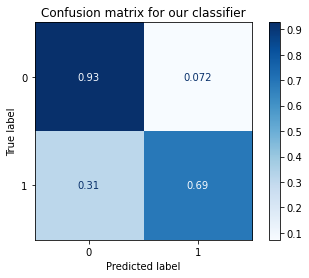

In [29]:
#generate confusion matrix
from sklearn.metrics import plot_confusion_matrix

matrix = plot_confusion_matrix(hist, test_text, test_target, cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

# **Module 3 - Retrieval of Relevant Tweets**


*   Creating a list of relevant tweets based on the predictions made by the machine learning model 
*   Relevant tweets are those with target value = 1




In [30]:
train_text1 , test_text1 , train_target1 , test_target1 = train_test_split(total_data, total_data['target'], test_size=0.2, random_state=2020) #split without CountVectorizing

In [31]:
 print(test_text1.columns.values.tolist())
 test_text_ncv = test_text1.values.tolist()
 print(type(test_text_ncv))
 print(test_text_ncv[0])

['id', 'keyword', 'location', 'text', 'target', 'hashtag', 'cleaned']
<class 'list'>
[2971, 'damage', 'Bangkok, Thailand', 'Nope! First he spoke what he thin… https://t.co/mPirnwMu2l', 0, [], ['Nope', 'First', 'he', 'spoke', 'what', 'he', 'thin']]


In [32]:
#display number of relevant predictions
count = 0
for i in model_pred :
  if i == 1 :
    count += 1
print(count)

408


In [33]:
#retrieve corresponding relevant tweets
index = 0
count = 0
rel_tweets = []
for i in model_pred :
  index += 1
  if i == 1 :
    rel_tweets.append(test_text_ncv[index][6])
    if test_text_ncv[index][4] == i:
      count = count + 1

In [34]:
for tweet in rel_tweets :
  tweet = ' '.join(tweet)

# **Module 4 - Location Based Tweets - GeoTag**


*   Parsing tweet text for locations (cities and countries)





In [35]:
! pip install geotext

In [36]:
from geotext import GeoText

In [37]:
list_of_places = [] 
for tweet in rel_tweets :
  list_of_places.append(GeoText(' '.join(tweet)))

# **Module 5 - Automatic Emergency Alerting Interface**


*   Creating a dataframe with the affected places and their corresponding tweets
*   Displaying a histogram depicting the areas most prone to disasters
*   Displaying a heat map depicting the areas most prone to disasters

In [38]:
places = []
total = []
corresponding_tweets = []
i = 0
for place in list_of_places:
  if (len(place.countries) > 0):
    places.append(place.countries)
    corresponding_tweets.append(' '.join(rel_tweets[i]))
    for p in place.countries:
      total.append(p)

  if (len(place.cities) > 0):
    places.append(place.cities)
    corresponding_tweets.append(' '.join(rel_tweets[i]))
    for p in place.cities:
      total.append(p)
  
  i = i + 1

In [39]:
print(places)
print(corresponding_tweets)

[['Taal'], ['Puerto Rico'], ['Australia'], ['Ho'], ['Brent'], ['Lucknow'], ['Union'], ['Most'], ['Washington'], ['Venice'], ['Australia'], ['Japan'], ['Talisay'], ['Australia'], ['Kenya', 'India', 'Israel'], ['Of'], ['Olympia'], ['Clinton'], ['Denmark'], ['Israel'], ['Vienna'], ['India'], ['Man'], ['Philippines'], ['Batangas'], ['Phoenix'], ['La Grange'], ['India'], ['Surfers Paradise'], ['Police', 'Kota'], ['Goldsboro'], ['Abuja'], ['Fier'], ['Jersey City'], ['Auburn'], ['China', 'Thailand'], ['Zhuhai'], ['Libya'], ['France'], ['Dover'], ['Warren'], ['Hitchin'], ['Taal'], ['Police'], ['Thailand', 'China'], ['Chile'], ['Iran'], ['Taiwan'], ['Iran'], ['Man'], ['Paris'], ['Israel'], ['Obama'], ['India', 'India']]
['Philippine authority are warning that a large dangerous eruption from the Taal volcano may be imminent after a t', 'Puerto Rico hit by another magnitude aftershock KYMA', 'Here we are in Australia in the middle of summer Trapped in our homesthe air outside filled with smoke fr

In [40]:
df = pd.DataFrame(list(zip(places, corresponding_tweets)),
               columns =['Countries/Cities', 'Corresponding Tweets'])

In [41]:
display(df)

,Countries/Cities,Corresponding Tweets
0,[Taal],Philippine authority are warning that a large ...
1,[Puerto Rico],Puerto Rico hit by another magnitude aftershoc...
2,[Australia],Here we are in Australia in the middle of summ...
3,[Ho],Geez Mike They couldnt get their Landcruisers ...
4,[Brent],I think it an aftershock from s lyrical beat d...
5,[Lucknow],Anti CAA ProtestrofRobin Verma released from L...
6,[Union],MEG issue Areal Flood Advisory for Alcorn Bent...
7,[Most],On Scorched Earth People Most of them have the...
8,[Washington],Washington ha an avalanche rescue goat His nam...
9,[Venice],Venice canal almost dry two month after severe...


In [42]:
countries = []
for places in list_of_places :
  for country in places.countries :
    countries.append(country)

cities = []
for places in list_of_places :
  for city in places.cities :
    cities.append(city)

In [43]:
print("COUNTRIES WITH DISASTERS:")
for country in countries :
    print(country)
print("\nCITIES WITH DISASTERS:")
for city in cities :
    print(city)

COUNTRIES WITH DISASTERS:
Puerto Rico
Australia
Australia
Japan
Australia
Kenya
India
Israel
Denmark
Israel
India
Philippines
India
China
Thailand
Libya
France
Thailand
China
Chile
Iran
Taiwan
Iran
Israel
India
India

CITIES WITH DISASTERS:
Taal
Ho
Brent
Lucknow
Union
Most
Washington
Venice
Talisay
Of
Olympia
Clinton
Vienna
Man
Batangas
Phoenix
La Grange
Surfers Paradise
Police
Kota
Goldsboro
Abuja
Fier
Jersey City
Auburn
Zhuhai
Dover
Warren
Hitchin
Taal
Police
Man
Paris
Obama


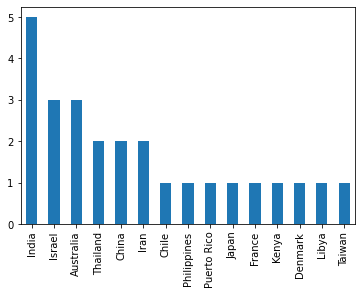

In [44]:
df = pd.DataFrame(list(zip(countries, cities)),
               columns =['Countries', 'Cities'])
fig, ax = plt.subplots()
df['Countries'].value_counts().plot(ax=ax, kind='bar')
plt.show() #country-wise

In [45]:
df1 = pd.DataFrame(list(zip(total)),
               columns =['Countries/Cities'])

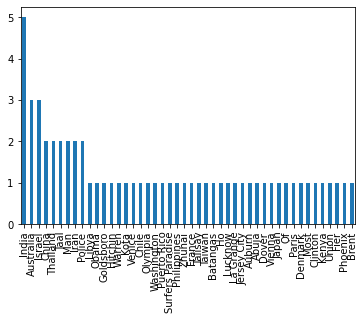

In [46]:
fig, ax = plt.subplots()
df1['Countries/Cities'].value_counts().plot(ax=ax, kind='bar')
plt.show() #countries and cities together

In [47]:
! pip install geopy 
! pip install Nominatim

In [48]:
from geopy.geocoders import Nominatim
#finding latitudes and longitudes
tot_lat = []
tot_long = []
occ_count = []
for place in total:
  address = place
  geolocator = Nominatim(user_agent="Your_Name")
  location = geolocator.geocode(address)
  tot_lat.append(location.latitude)
  tot_long.append(location.longitude)
  occ_count.append(total.count(place))

In [49]:
df2 = pd.DataFrame(list(zip(total, tot_lat, tot_long, occ_count)),
               columns =['Countries/Cities', 'Latitude', 'Longitude', 'Occurrence Count'])
display(df2)

,Countries/Cities,Latitude,Longitude,Occurrence Count
0,Taal,13.880182,120.923272,2
1,Puerto Rico,18.198977,-66.261522,1
2,Australia,-24.776109,134.755000,3
3,Ho,27.719810,56.335807,1
4,Brent,32.937346,-87.164718,1
5,Lucknow,26.838100,80.934600,1
6,Union,37.461645,-89.250479,1
7,Most,50.503274,13.636112,1
8,Washington,38.895037,-77.036543,1
9,Venice,45.437191,12.334590,1


In [50]:
! pip install basemap #drawing world map

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [52]:
from itertools import chain

def draw_map(m, scale=0.2):
    #draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    #lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    #keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    #cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

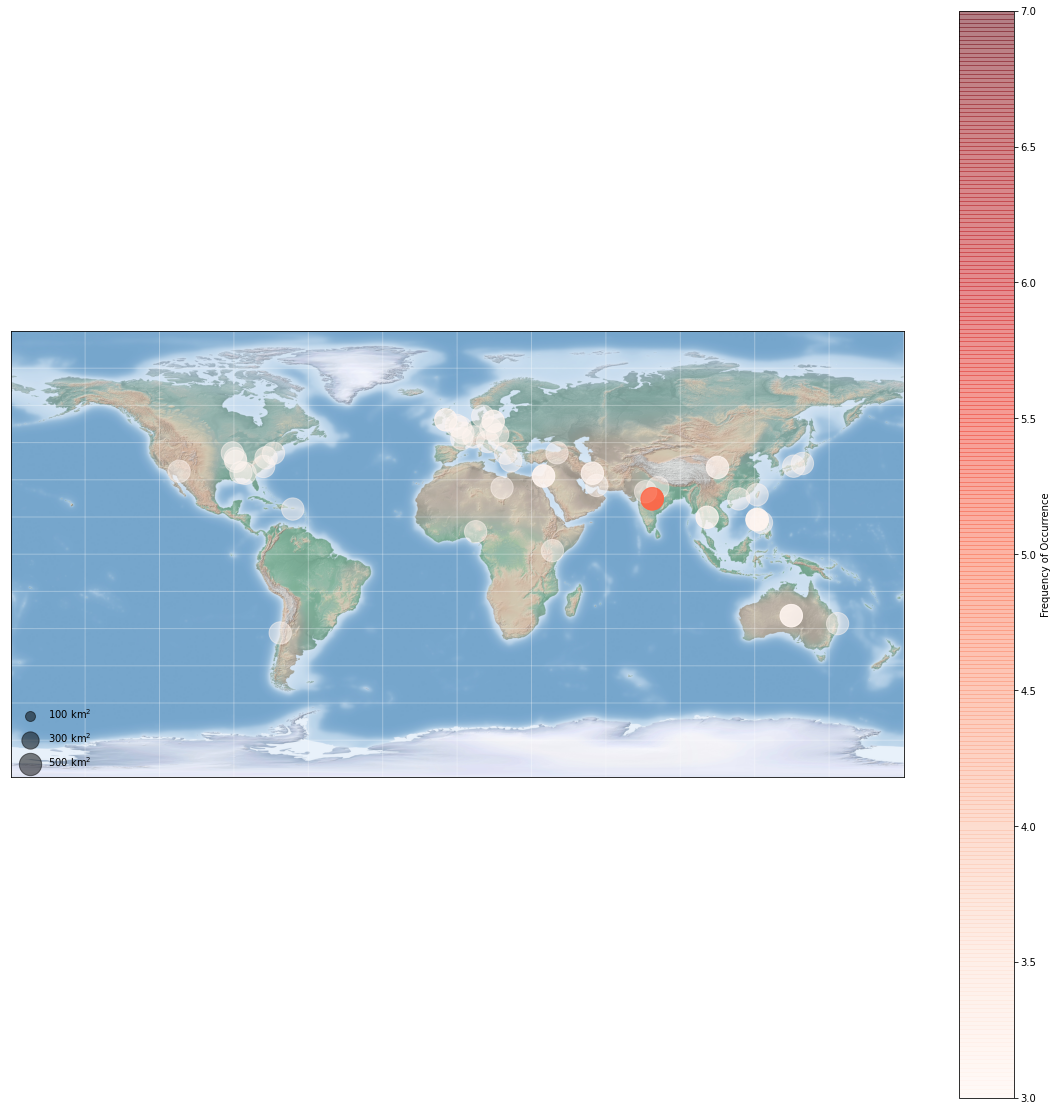

In [53]:
fig = plt.figure(figsize=(20, 20), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)

#2. scatter city data, with color reflecting population
#and size reflecting area
m.scatter(df2['Longitude'].values, df2['Latitude'].values, latlon=True, 
          c = df2['Occurrence Count'].values, s = 500,
          cmap = 'Reds', alpha = 0.5)

#3. create colorbar and legend
plt.colorbar(label=r'Frequency of Occurrence')
plt.clim(3, 7)

#make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');